In [1]:
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.jit as jit
import warnings
from collections import namedtuple
from typing import List, Tuple
from torch import Tensor
import numbers
import numpy as np
from scipy.integrate import quad
import copy
from scipy.integrate import quad
from torch.autograd import Variable
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
from torchviz import make_dot

# constants

In [3]:
window_len = 50

# import data

In [4]:
df_message = pd.read_csv('data/clean/AMZN_message_data.csv',index_col=0)
df_orders = pd.read_csv('data/clean/AMZN_orderbook_data.csv')

In [5]:
df_orders

,Unnamed: 0,ask price 1,ask size 1,bid price 1,bid size 1,ask price 2,ask size 2,bid price 2,bid size 2,ask price 3,...,bid size 3,ask price 4,ask size 4,bid price 4,bid size 4,ask price 5,ask size 5,bid price 5,bid size 5,state indicator
0,0,2239500,100,2238100,21,2239900,100,2231800,100,2240000,...,200,2242500,100,2230400,100,2244000,547,2230000,10,0.0
1,1,2239500,100,2238100,21,2239600,20,2231800,100,2239900,...,200,2240000,220,2230400,100,2242500,100,2230000,10,0.0
2,2,2239500,100,2238100,21,2239600,20,2237500,100,2239900,...,100,2240000,220,2230700,200,2242500,100,2230400,100,0.0
3,3,2239500,100,2238100,21,2239600,20,2237500,100,2239900,...,100,2240000,233,2230700,200,2242500,100,2230400,100,0.0
4,4,2239500,100,2238100,21,2239600,20,2237500,100,2239900,...,2,2240000,233,2231800,100,2242500,100,2230700,200,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144061,144061,2206200,100,2205100,309,2206400,100,2205000,71,2206500,...,700,2206700,170,2204700,100,2206900,170,2204600,1704,2.0
144062,144062,2206400,100,2205100,249,2206500,1290,2205000,71,2206700,...,700,2206900,170,2204700,100,2207100,1800,2204600,1704,2.0
144063,144063,2206400,100,2205100,249,2206500,1290,2205000,71,2206700,...,700,2207100,1800,2204700,100,2207400,800,2204600,1704,2.0
144064,144064,2206300,100,2205100,249,2206400,100,2205000,71,2206500,...,700,2206700,170,2204700,100,2207100,1800,2204600,1704,2.0


In [6]:
time_raw = df_message['time'].to_numpy()
events_raw = df_message['event type thesis'].to_numpy()
states_raw = df_orders['state indicator'].to_numpy()

In [7]:
def split_rolling_window(arr, window_len):
    return sliding_window_view(arr, window_shape = window_len)

In [8]:
time = split_rolling_window(time_raw, window_len)
events = split_rolling_window(events_raw, window_len)
states = split_rolling_window(states_raw, window_len)
trans_mtrx = np.load('data/transition_matrices/AMZN_matrix.npy')

# define cell


In [9]:
class LSTMLayerStacked(nn.Module):
    def __init__(self, cell, input_size, hidden_size, t):
        super().__init__()
        self.stackedcell = LSTMStackedCells(cell, input_size, hidden_size)
        self.num_layers = 4
        self.hidden_size = hidden_size
        self.embed_layer = Embed_layer(input_size, hidden_size)
        self.h_input_merge_LC = Hidden_sharing_layer(5*hidden_size, 4*hidden_size)
        self.intensity_functions = []
        self.t_seq = t
        
    def forward(self, inputs):
        
        X, t_seq = inputs
        first_run = True
        
        h1, h2, h3, h4 = [Variable(torch.randn(self.hidden_size)) for i in range(4)]
        c1_1, c2_1, c3_1, c4_1 = [Variable(torch.randn(self.hidden_size)) for i in range(4)]
        c1_2, c2_2, c3_2, c4_2 = [Variable(torch.randn(self.hidden_size)) for i in range(4)]
        
        i=0
        
        for x, tj in zip(X, self.t_seq):
            embedded_input = self.embed_layer(x)
            
            if not first_run: #TODO bit messy way to initialise run & set cell states. Clean it up if time left
#                 c1_1, c2_1, c3_1, c4_1 = self.fill_in_func(c1_func_list, tj)
#                 h1, h2, h3, h4 = self.fill_in_func(h_func_list, tj)
#                 c1_2, c2_2, c3_2, c4_2 = c2_list
                
                h1, h2, h3, h4 = [Variable(torch.randn(self.hidden_size)) for i in range(4)] #remove
                c1_1, c2_1, c3_1, c4_1 = [Variable(torch.randn(self.hidden_size)) for i in range(4)]
                c1_2, c2_2, c3_2, c4_2 = [Variable(torch.randn(self.hidden_size)) for i in range(4)]
                
#             h1, h2, h3, h4 = self.process_hidden_states_and_input(embedded_input, h1, h2, h3, h4)
            
            h1, h2, h3, h4 = [Variable(torch.randn(self.hidden_size)) for i in range(4)] #remove
            
            state = [(h1, c1_1, c1_2), (h2, c2_1, c2_2), (h3, c3_1, c3_2), (h4, c4_1, c4_2)]
            
            c2_list, c1_func_list, h_func_list, intensity_functions = self.stackedcell((state, tj))
            
            self.intensity_functions.append(intensity_functions)
            
            first_run = False
            
            
            print(f'LSTM LAYER RUN: {i}')
            i += 1
            
        return self.intensity_functions
            
    def process_hidden_states_and_input(self, embedded_input, h1, h2, h3, h4):
        h_merged_with_input =  self.h_input_merge_LC(torch.concat([embedded_input, h1, h2, h3, h4]))
        
        h1, h2, h3, h4 = torch.split(h_merged_with_input, self.hidden_size)
    
        return h1, h2, h3, h4
    
            
    def fill_in_func(self, func, tj):
        f1, f2, f3, f4 = func[0](tj), func[1](tj), func[2](tj), func[3](tj)
        return (f1, f2, f3, f4)
    
class LSTMStackedCells(nn.Module):
    def __init__(self, cell, input_size, hidden_size):
        super().__init__()
        self.cell1 = cell(hidden_size, hidden_size)
        self.cell2 = cell(hidden_size, hidden_size)
        self.cell3 = cell(hidden_size, hidden_size)
        self.cell4 = cell(hidden_size, hidden_size)
        
    def forward(self, inputs):
        state, tj = inputs
        
        state1, state2, state3, state4 = state
        
        c1_2, c1_1_func, h1_func = self.cell1((state1, tj))
        c2_2, c2_1_func, h2_func = self.cell2((state2, tj))
        c3_2, c3_1_func, h3_func = self.cell3((state3, tj))
        c4_2, c4_1_func, h4_func = self.cell4((state4, tj))
        
        intensity_functions = self.get_intensity_functions()
        c2_list = [c1_2, c2_2, c3_2, c4_2]
        c1_func_list = [c1_1_func, c2_1_func, c3_1_func, c4_1_func]
        h_func_list = [h1_func, h2_func, h3_func, h4_func]
        
        return c2_list, c1_func_list, h_func_list, intensity_functions

    def get_intensity_functions(self): #using copies since the constants in object used for f() will be changing through time. TODO: add function and variable to a seperate dataclass that can be saved and isn't as clunky.
        f1 = self.cell1.get_frozen_intensity_function()
        f2 = self.cell2.get_frozen_intensity_function()
        f3 = self.cell3.get_frozen_intensity_function()
        f4 = self.cell4.get_frozen_intensity_function()
        return [f1, f2, f3, f4]

In [10]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size = 16):
        super().__init__()
        self.Tanh = nn.Tanh()
        self.Softplus = nn.Softplus()
        
        self.LC_i1 = Gate_network(input_size, hidden_size)
        self.LC_i2 = Gate_network(input_size, hidden_size)
        self.LC_f1 = Gate_network(input_size, hidden_size)
        self.LC_f2 = Gate_network(input_size, hidden_size)
        self.LC_o = Gate_network(input_size, hidden_size)
        self.LC_z = Gate_network(input_size, hidden_size)
        self.LC_d = Decay_network(input_size, hidden_size)
        self.LC_lambda = Decode_layer(input_size, hidden_size)
        
        self.tj = None
        self.cy1 = None
        self.cy2 = None
        self.decay_coef = None
        self.o = None
        
        
    def forward(self, inputs):
        state, tj = inputs
        self.tj = tj
        
        hx, cx1, cx2 = state
        
        i1 = self.LC_i1(hx)
        i2 = self.LC_i2(hx)
        f1 = self.LC_f1(hx)
        f2 = self.LC_f2(hx)
        o = self.LC_o(hx)
        z = self.Tanh(self.LC_z(hx))

        self.o = o
        self.cy1 = (f1 * cx1) + (i1 * z)
        self.cy2 = (f2 * cx2) + (i2 * z)
        self.decay_coef = self.LC_d(hx)
        
        return self.cy2, self.get_c, self.get_h
        
    def get_frozen_intensity_function(self): #variables are put in data_class so they become constants.
        intensity_dataclass = Intensity_func_and_constants(self.tj, self.cy1, self.cy2, self.decay_coef, self.o, self.LC_lambda)
        return intensity_dataclass.get_intensity_function()
        
    def get_intensity(self, t):
        h_t = self.get_h(t)
        intensity = self.LC_lambda(h_t)
        return intensity
        
    def get_h(self, t):
        c_t = self.get_c(t)
        h_t = self.o * self.Tanh(c_t)
        return h_t

    def get_c(self, t):
        c_t = self.cy2 + (self.cy1 - self.cy2)*torch.exp(-self.decay_coef*(t - self.tj))
        return c_t
    
class Intensity_func_and_constants():
    def __init__(self, tj, c1, c2, decay_coeff, o, LC_lambda):
        self.tj = tj
        self.cy1 = c1
        self.cy2 = c2
        self.decay_coef = decay_coeff       
        self.o = o
        self.LC_lambda = LC_lambda
        self.tanh = nn.Tanh()
            
    def get_intensity_function(self):
        return self.get_intensity
            
    def get_intensity(self, t):
        h_t = self.get_h(t)
        intensity = self.LC_lambda(h_t)
        return intensity
        
    def get_h(self, t):
        c_t = self.get_c(t)
        h_t = self.o * self.tanh(c_t)
        return h_t

    def get_c(self, t):
        c_t = self.cy2 + (self.cy1 - self.cy2)*torch.exp(-self.decay_coef*(t - self.tj))
        return c_t

In [11]:
class Gate_network(nn.Module):
    def __init__(self, input_size, hidden_size = 16):
        super().__init__()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, input: Tensor):
        x = self.tanh(self.layer1(input))
        x = self.tanh(self.layer2(x))
        return self.sigmoid(x)
    
class Decay_network(nn.Module):
    def __init__(self, input_size, hidden_size = 16):
        super().__init__()
        self.softplus = nn.Softplus()
        
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, input: Tensor):
        x = self.softplus(self.layer1(input))
        x = self.softplus(self.layer2(x))
        return x
    
class Decode_layer(nn.Module):
    def __init__(self, input_size, hidden_size = 16):
        super().__init__()
        self.softplus = nn.Softplus()
        
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, input: Tensor):
        x = self.softplus(self.layer1(input))
        x = self.softplus(self.output_layer(x))
        return x

class Embed_layer(nn.Module):
    def __init__(self, input_size, hidden_size = 16):
        super().__init__()
        self.tanh = nn.Tanh()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, input: Tensor):
        x = self.tanh(self.layer1(input))
        x = self.tanh(self.layer2(x))
        return x
    
class Hidden_sharing_layer(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.tanh = nn.Tanh()
        self.layer1 = nn.Linear(input_size, output_size)
        self.layer2 = nn.Linear(output_size, output_size)
        
    def forward(self, input: Tensor):
        x = self.tanh(self.layer1(input))
        x = self.tanh(self.layer2(x))
        return x

# Train def

In [12]:
torch.autograd.set_detect_anomaly(False)

In [13]:
model = LSTMLayerStacked(LSTMCell, 2, 16, time[0])
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.002)

In [14]:
train_one_epoch(torch.randn(len(time), window_len, 2)) #error happened after moving time from initialization to forward.

NameError: name 'train_one_epoch' is not defined

In [15]:
y = model((torch.randn(window_len,2), time[0]))

LSTM LAYER RUN: 0
LSTM LAYER RUN: 1
LSTM LAYER RUN: 2
LSTM LAYER RUN: 3
LSTM LAYER RUN: 4
LSTM LAYER RUN: 5
LSTM LAYER RUN: 6
LSTM LAYER RUN: 7
LSTM LAYER RUN: 8
LSTM LAYER RUN: 9
LSTM LAYER RUN: 10
LSTM LAYER RUN: 11
LSTM LAYER RUN: 12
LSTM LAYER RUN: 13
LSTM LAYER RUN: 14
LSTM LAYER RUN: 15
LSTM LAYER RUN: 16
LSTM LAYER RUN: 17
LSTM LAYER RUN: 18
LSTM LAYER RUN: 19
LSTM LAYER RUN: 20
LSTM LAYER RUN: 21
LSTM LAYER RUN: 22
LSTM LAYER RUN: 23
LSTM LAYER RUN: 24
LSTM LAYER RUN: 25
LSTM LAYER RUN: 26
LSTM LAYER RUN: 27
LSTM LAYER RUN: 28
LSTM LAYER RUN: 29
LSTM LAYER RUN: 30
LSTM LAYER RUN: 31
LSTM LAYER RUN: 32
LSTM LAYER RUN: 33
LSTM LAYER RUN: 34
LSTM LAYER RUN: 35
LSTM LAYER RUN: 36
LSTM LAYER RUN: 37
LSTM LAYER RUN: 38
LSTM LAYER RUN: 39
LSTM LAYER RUN: 40
LSTM LAYER RUN: 41
LSTM LAYER RUN: 42
LSTM LAYER RUN: 43
LSTM LAYER RUN: 44
LSTM LAYER RUN: 45
LSTM LAYER RUN: 46
LSTM LAYER RUN: 47
LSTM LAYER RUN: 48
LSTM LAYER RUN: 49


In [16]:
y = y[-1][3](3)

In [18]:
make_dot(y).render("attached", format="png")

'attached.png'

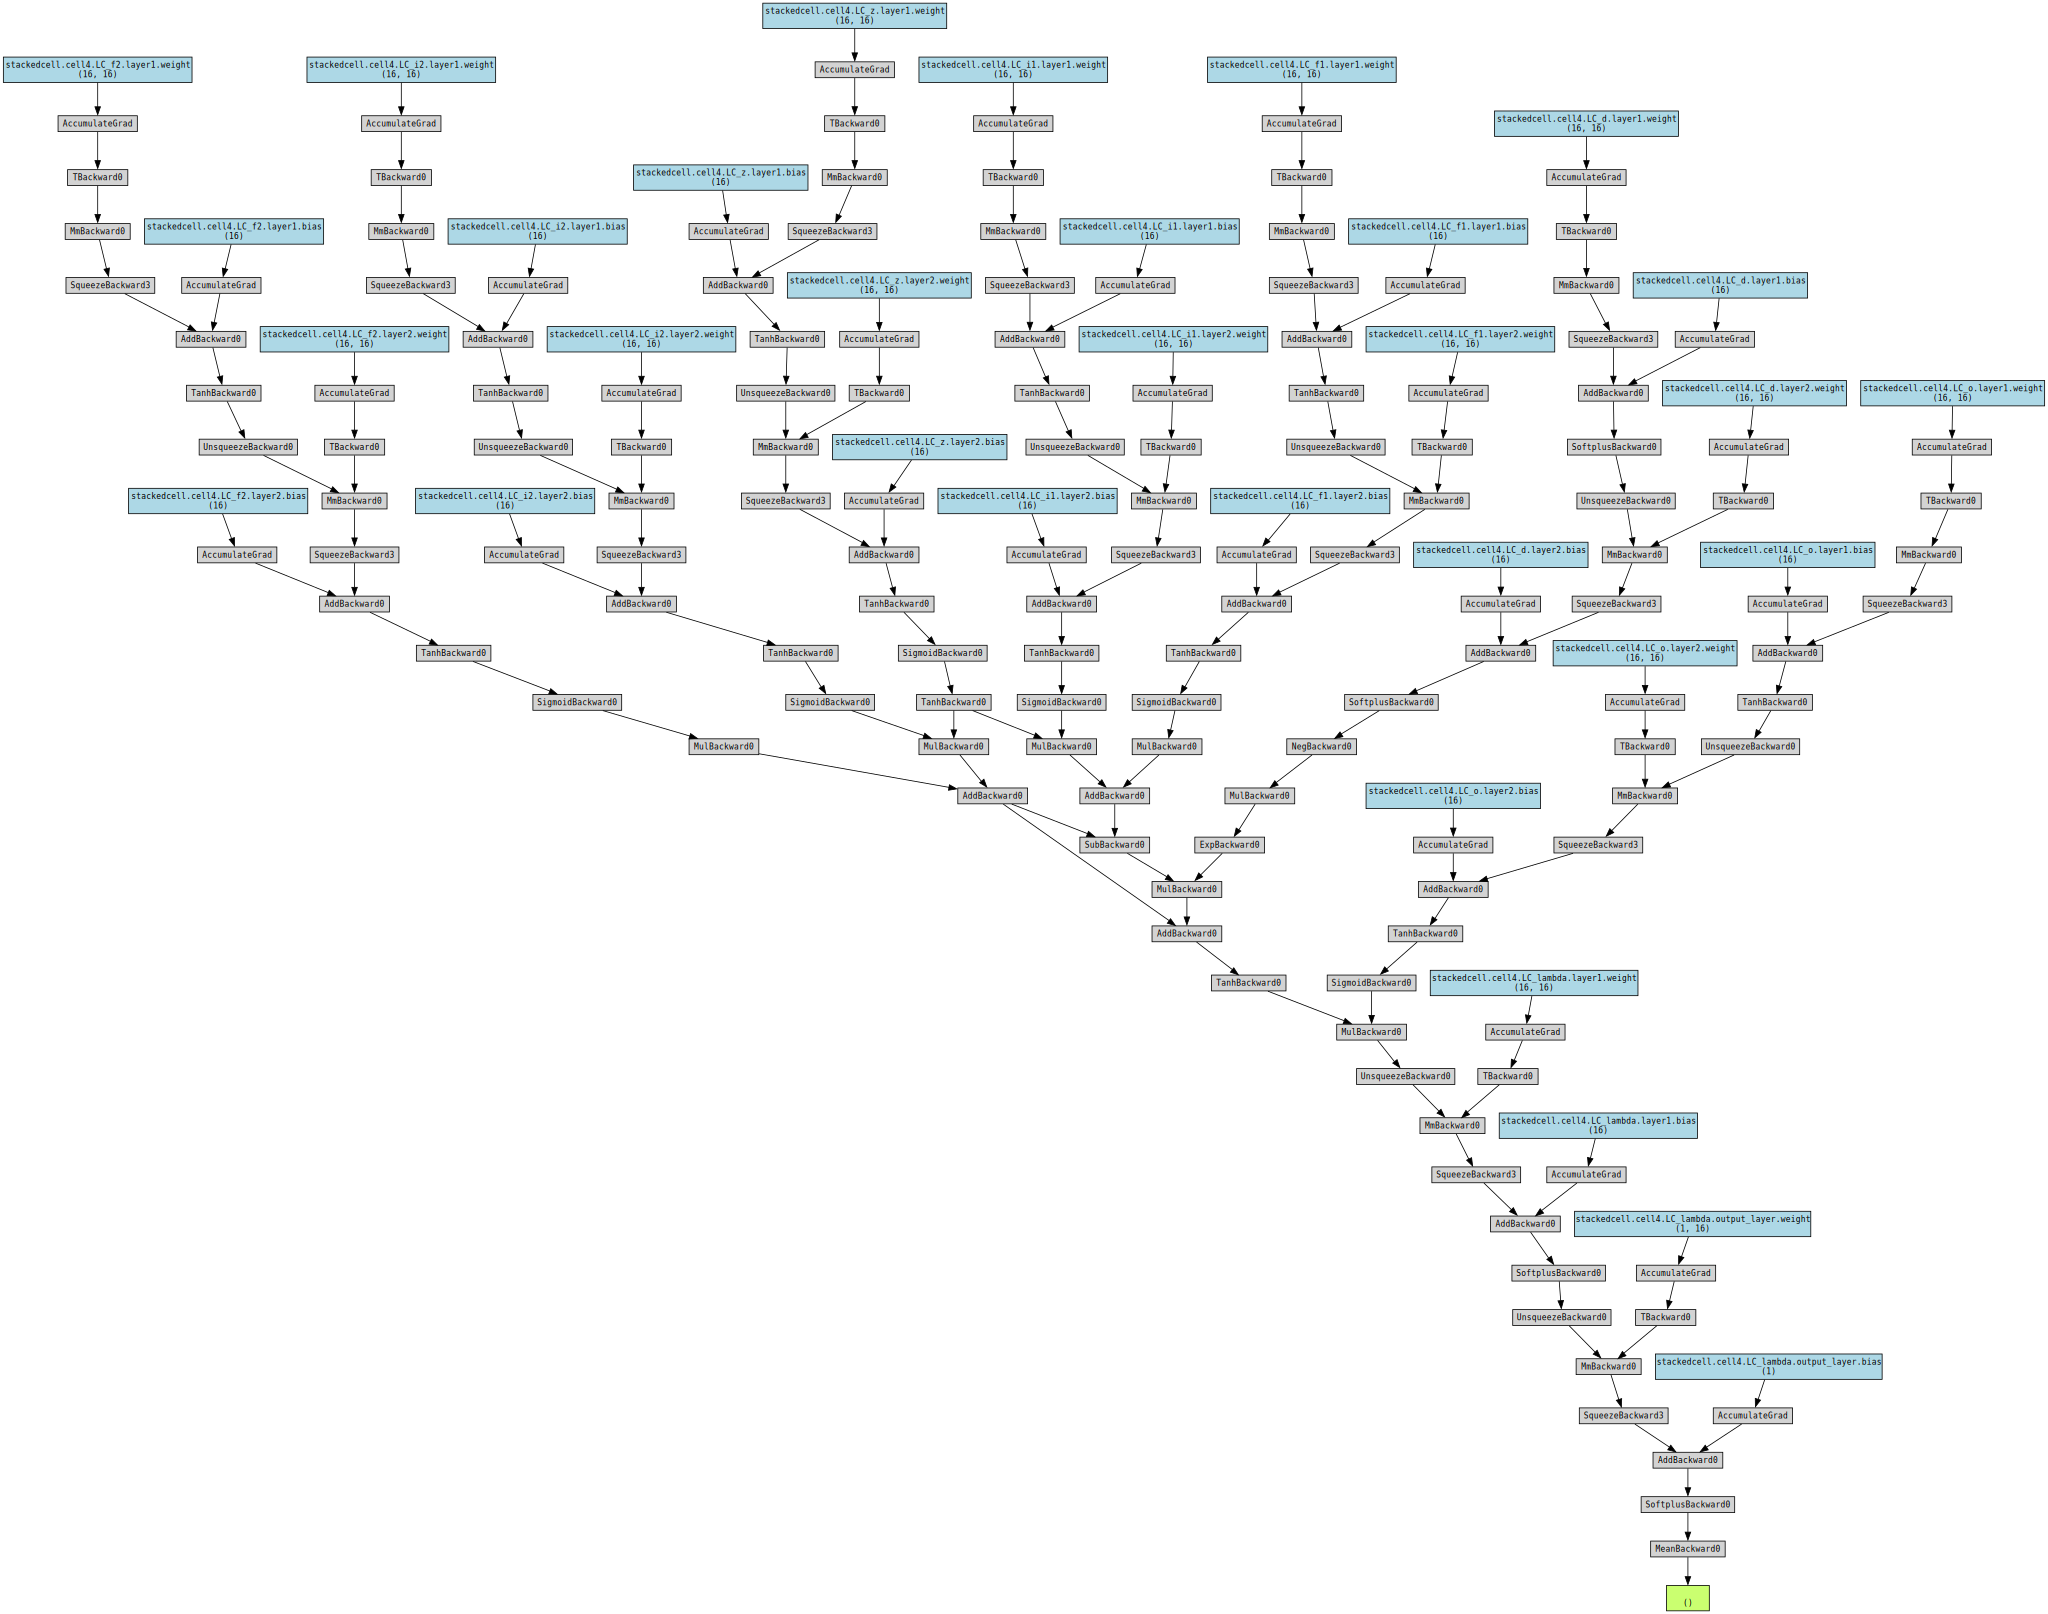

In [17]:
make_dot(y.mean(), params=dict(model.named_parameters()))

In [14]:
def train_one_epoch(data):
    
    torch.autograd.set_detect_anomaly(False)
    
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, inputs in enumerate(data):
        print(inputs)
        # Every data instance is an input + label pair
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        intensity_funcs = model((inputs, time[0]))
        loss_fn = HawkesLoss(intensity_funcs, time[i], events[i], trans_mtrx, states[i])
        
        # Compute the loss and its gradients
        loss = loss_fn()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

# loss function

In [15]:
class HawkesLoss(nn.Module):
    def __init__(self, intensity_functions, t_seq, event_seq, trans_mtrx, state_seq):
        super().__init__()
        self.intensity_functions = intensity_functions
        self.t_seq = t_seq
        self.event_seq = event_seq
        self.trans_mtrx = trans_mtrx
        self.state_seq = state_seq
        self.t_intervals = self.get_time_intervals()
        self.n1, self.n2 = 1, 1
        self.n_k = 4
        
        print(f'hawkes loss is initiated')
        
    def get_time_intervals(self):
        return np.hstack([self.t_seq[:-1, np.newaxis], self.t_seq[1:, np.newaxis]])

    def forward(self):
        n1, n2 = np.random.randn(2)    #FOR NOW RANDOM WEIGHTING COEFFICIENT. MAYBE MAKE DETERMINISTIC LATER
        print(f'debug: before l1')
        L1 = self.get_L1()
        print(f'debug: before L2')
        L2 = self.get_L2()
        print(f'debug: before L3')
        L3 = self.get_L3()
        hawkes_loss = L1 - self.n1*L2 + self.n2*L3 
        return hawkes_loss

    def get_L1(self):
        sum_L1 = 0
        for i, (t_begin, t_end) in enumerate(self.t_intervals):
            k = self.event_seq[i]
            intensity_new_k = self.intensity_functions[i][k]
            old_intensity_functions = self.intensity_functions[i - 1]
            total_intensity_integral = self.get_summed_intensity_integral(old_intensity_functions, t_begin, t_end)
            sum_L1 = sum_L1 + torch.log(intensity_new_k(t_end)) - total_intensity_integral
        return sum_L1

    def get_summed_intensity_integral(self, intensity_functions, t_begin, t_end):
        total_integral = 0
        for function in intensity_functions:
            total_integral = total_integral + quad(function, t_begin, t_end)[0]
        return total_integral

    def get_L2(self):
        sum_L2 = 0
        for i in range(len(self.event_seq) - 1):
            event = self.event_seq[i]
            tjplus1 = self.t_seq[i+1]
            event_intensity_function = self.intensity_functions[i][event]
            intesity_event = event_intensity_function(tjplus1)
            sum_L2 = sum_L2 - torch.log(intesity_event)
        return sum_L2

    def get_L3(self):
        sum_L3 = 0
        for i in range(0, len(self.event_seq) - 1):
            yiplus1 = int(self.event_seq[i + 1])
            xi = int(self.state_seq[i])
            xiplus1 = int(self.state_seq[i + 1])
            transition_prob = self.trans_mtrx[yiplus1][xi][xiplus1]
            sum_L3 = sum_L3 + np.log(transition_prob)
        return sum_L3
    

In [78]:
a = [[2,3], [3,4]]

In [79]:
a.append([4,5])

In [3]:
import numpy as np


In [8]:
np.random.randn(3).float()

AttributeError: 'numpy.ndarray' object has no attribute 'float'